# Hotel Booking Cancellation Analysis and Prediction

Source of the dataset:
https://www.kaggle.com/datasets/youssefaboelwafa/hotel-booking-cancellation-prediction/data

This is a fairly new data set which was uploaded in early Dec 2023.

This mini project aims to provide the following analyses:
1. Time Series EDA
2. Features EDA and Data Analysis
3. ML Modelling and some quick and basic optimization trials
    1. Model selection
    2. Features Backward selection
    3. RandomizedGridSearch

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import time

from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import the data
df = pd.read_csv("booking.csv")
df.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


## 1. EDA and Data Cleaning

In [4]:
# Check the information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

In [5]:
df.describe()

,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,special requests
count,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000
mean,1.844839,0.105360,0.810693,2.204602,0.030977,85.239851,0.025630,0.023343,0.153369,103.421636,0.619733
std,0.518813,0.402704,0.870590,1.410946,0.173258,85.938796,0.158032,0.368281,1.753931,35.086469,0.786262
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [6]:
df["date of reservation"][:5]

0    10/2/2015
1    11/6/2018
2    2/28/2018
3    5/20/2017
4    4/11/2018
Name: date of reservation, dtype: object

In [7]:
# Remove the rows with the date of "2018-2-29" as it is incorrest information since year 2018 is not a leap year, on top of that there aren't many rows with this wrong date info.
df = df[df["date of reservation"] != "2018-2-29"]

In [8]:
# Check if there is still any row with the wrong date of "2018-2-29"
df[df["date of reservation"] == "2018-2-29"]

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status


In [9]:
# Convert the date column into datetime format
df["date of reservation"] = pd.to_datetime(df["date of reservation"], infer_datetime_format=True)

In [10]:
# Check the information of the DataFrame again
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36248 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Booking_ID                36248 non-null  object        
 1   number of adults          36248 non-null  int64         
 2   number of children        36248 non-null  int64         
 3   number of weekend nights  36248 non-null  int64         
 4   number of week nights     36248 non-null  int64         
 5   type of meal              36248 non-null  object        
 6   car parking space         36248 non-null  int64         
 7   room type                 36248 non-null  object        
 8   lead time                 36248 non-null  int64         
 9   market segment type       36248 non-null  object        
 10  repeated                  36248 non-null  int64         
 11  P-C                       36248 non-null  int64         
 12  P-not-C                

In [11]:
# One-Hot encode the categorical columns
df_dummies = pd.get_dummies(df, columns=["type of meal", "room type", "market segment type", "booking status"], drop_first=True)
df_dummies.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,...,room type_Room_Type 3,room type_Room_Type 4,room type_Room_Type 5,room type_Room_Type 6,room type_Room_Type 7,market segment type_Complementary,market segment type_Corporate,market segment type_Offline,market segment type_Online,booking status_Not_Canceled
0,INN00001,1,1,2,5,0,224,0,0,0,...,False,False,False,False,False,False,False,True,False,True
1,INN00002,1,0,1,3,0,5,0,0,0,...,False,False,False,False,False,False,False,False,True,True
2,INN00003,2,1,1,3,0,1,0,0,0,...,False,False,False,False,False,False,False,False,True,False
3,INN00004,1,0,0,2,0,211,0,0,0,...,False,False,False,False,False,False,False,False,True,False
4,INN00005,1,0,1,2,0,48,0,0,0,...,False,False,False,False,False,False,False,False,True,False


### 1.1 Time Series Analysis

In [12]:
# Group the data by "date of reservation"
df_grouped = df_dummies.groupby("date of reservation")[["Booking_ID", "booking status_Not_Canceled"]].nunique().reset_index()
df_grouped.head()

,date of reservation,Booking_ID,booking status_Not_Canceled
0,2015-10-02,1,1
1,2016-09-13,1,1
2,2017-05-20,1,1
3,2017-07-01,68,2
4,2017-07-02,5,1


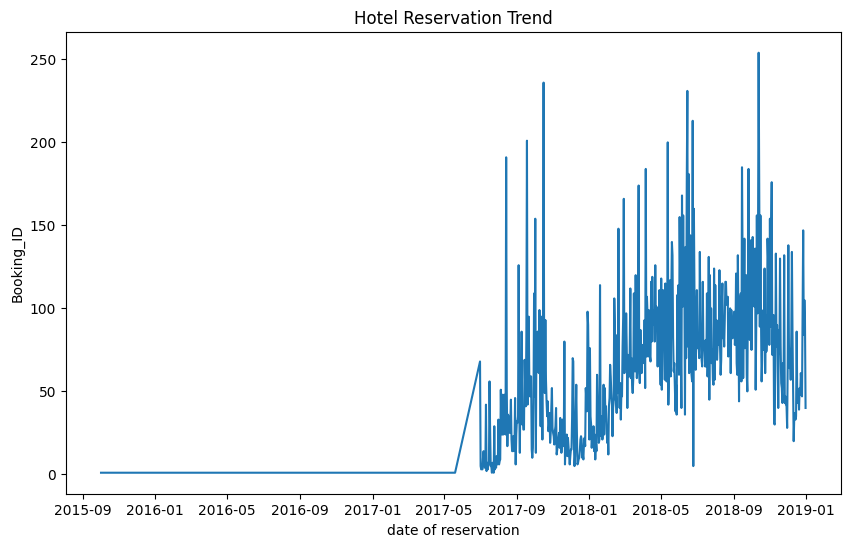

In [13]:
# Create time series plot
plt.figure(figsize=(10,6))
sns.lineplot(x=df_grouped["date of reservation"], y=df_grouped["Booking_ID"])
plt.title("Hotel Reservation Trend")
plt.show();

In [14]:
# To confirm whether some years have really low booking count(s)
df_grouped[df_grouped["date of reservation"].dt.year == 2016]

,date of reservation,Booking_ID,booking status_Not_Canceled
1,2016-09-13,1,1


Hotel industry could be a seasonal business, where the amount of bookings can be affected by seasons due to tourism or business needs.

From the time series plot above there seems to be some up and down trends to it.

Therefore for the next section we will break down and group the booking data by years and months to check if there is any pattern to it.

In [15]:
# Create new column of year and month
df_grouped["month"] = df_grouped["date of reservation"].dt.month
df_grouped["year"] = df_grouped["date of reservation"].dt.year
df_grouped.head()

,date of reservation,Booking_ID,booking status_Not_Canceled,month,year
0,2015-10-02,1,1,10,2015
1,2016-09-13,1,1,9,2016
2,2017-05-20,1,1,5,2017
3,2017-07-01,68,2,7,2017
4,2017-07-02,5,1,7,2017


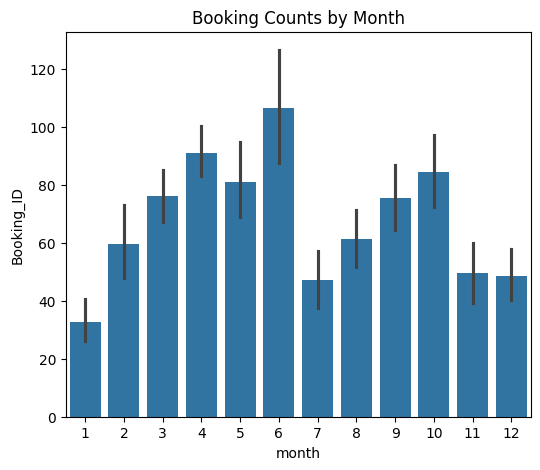

In [16]:
# Create column plot by months
plt.figure(figsize=(6, 5))
sns.barplot(x=df_grouped["month"], y=df_grouped["Booking_ID"])
plt.title("Booking Counts by Month")
plt.show();

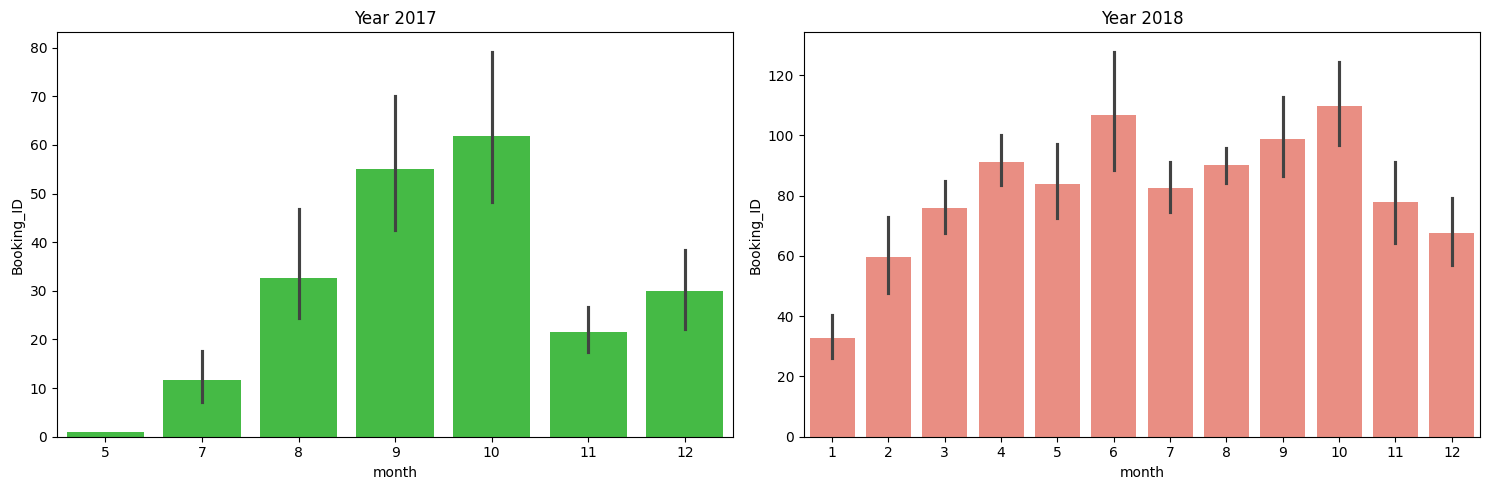

In [17]:
# Further breakdown by year 2017 and 2018 to confirm the pattern is consistent in different years.
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1,2,1)
sns.barplot(x=df_grouped[df_grouped["year"]==2017]["month"], y=df_grouped[df_grouped["year"]==2017]["Booking_ID"], ax=ax1, color="limegreen")
ax1.set_title("Year 2017")

ax2 = fig.add_subplot(1,2,2)
sns.barplot(x=df_grouped[df_grouped["year"]==2018]["month"], y=df_grouped[df_grouped["year"]==2018]["Booking_ID"], ax=ax2, color="salmon")
ax2.set_title("Year 2018")

plt.tight_layout()
plt.show();

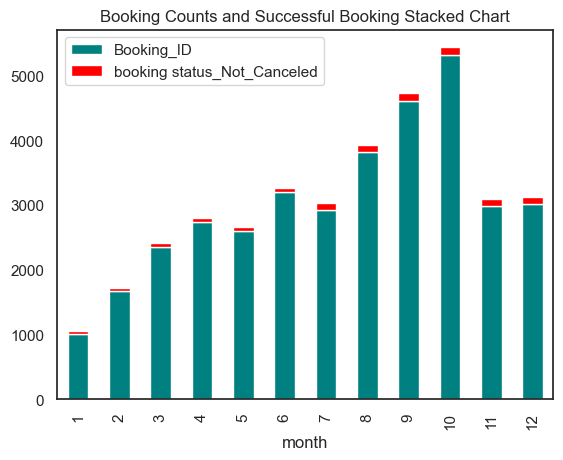

In [18]:
# Set seaborn plotting aesthetics
sns.set(style='white')

df_plot_not_cancelled = df_grouped[["month", "Booking_ID", "booking status_Not_Canceled"]]
df_plot_not_cancelled.set_index("month", inplace=True)
df_plot_not_cancelled = df_plot_not_cancelled.groupby("month").sum()
df_plot_not_cancelled.plot(kind="bar", stacked=True, color=["teal", "red"], title="Booking Counts and Successful Booking Stacked Chart", legend=["Booking Counts", "Successful Booking"])

plt.show();

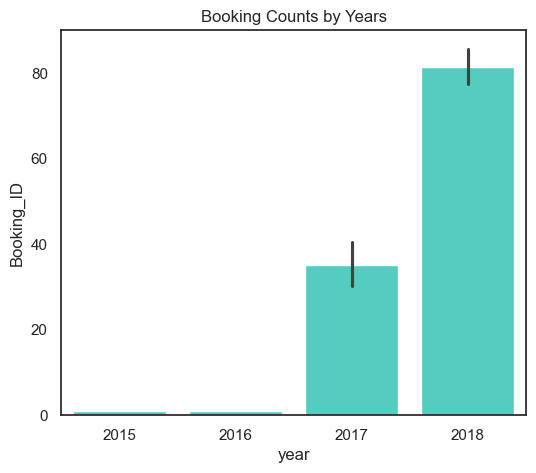

In [19]:
# Set seaborn plotting aesthetics
sns.set(style='white')

plt.figure(figsize=(6, 5))
sns.barplot(x=df_grouped["year"], y=df_grouped["Booking_ID"], color="turquoise")
plt.title("Booking Counts by Years")
plt.show();

Apparently, the business of this hotel is just picking up from year 2015 to year 2018

1. Unfortunately the source of the data is not shared by the author, hence further analysis of the business situation with holidays, weather patterns and events cannot be made.
2. This is not a very large dataset anyway especially this seems to be a startup hotel in which business was just picking up, hence time series analysis is not able to shed much light on the seasonal patterns.
3. But it's also strange even for a startup hotel to have only 1 booking in year 2015 and 2016, which doesn't make sense. The logical possibility to this could be that the systematic was not setup yet hence the bookings data in year 2015 and 2016 was not recorded.

But the key thing here is about the thought-process of analyzing such time series data which is related to hotel / tourism industry. If the information of the specific country and Hotel name of this data is made available, we can further correlate this data with seasons, weather patterns and etc. to offer more insights.



### 1.2 EDA for Categorical Data

In [20]:
# Preview the data (w/o one-hot encoding) in df again
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36248 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Booking_ID                36248 non-null  object        
 1   number of adults          36248 non-null  int64         
 2   number of children        36248 non-null  int64         
 3   number of weekend nights  36248 non-null  int64         
 4   number of week nights     36248 non-null  int64         
 5   type of meal              36248 non-null  object        
 6   car parking space         36248 non-null  int64         
 7   room type                 36248 non-null  object        
 8   lead time                 36248 non-null  int64         
 9   market segment type       36248 non-null  object        
 10  repeated                  36248 non-null  int64         
 11  P-C                       36248 non-null  int64         
 12  P-not-C                

In [21]:
# Create a list of categorical features
cat_list = df.columns.to_list()
remove_list = ["Booking_ID", "lead time", "average price", "date of reservation"]
cat_list = [item for item in cat_list if item not in remove_list]
cat_list

['number of adults',
 'number of children',
 'number of weekend nights',
 'number of week nights',
 'type of meal',
 'car parking space',
 'room type',
 'market segment type',
 'repeated',
 'P-C',
 'P-not-C',
 'special requests',
 'booking status']

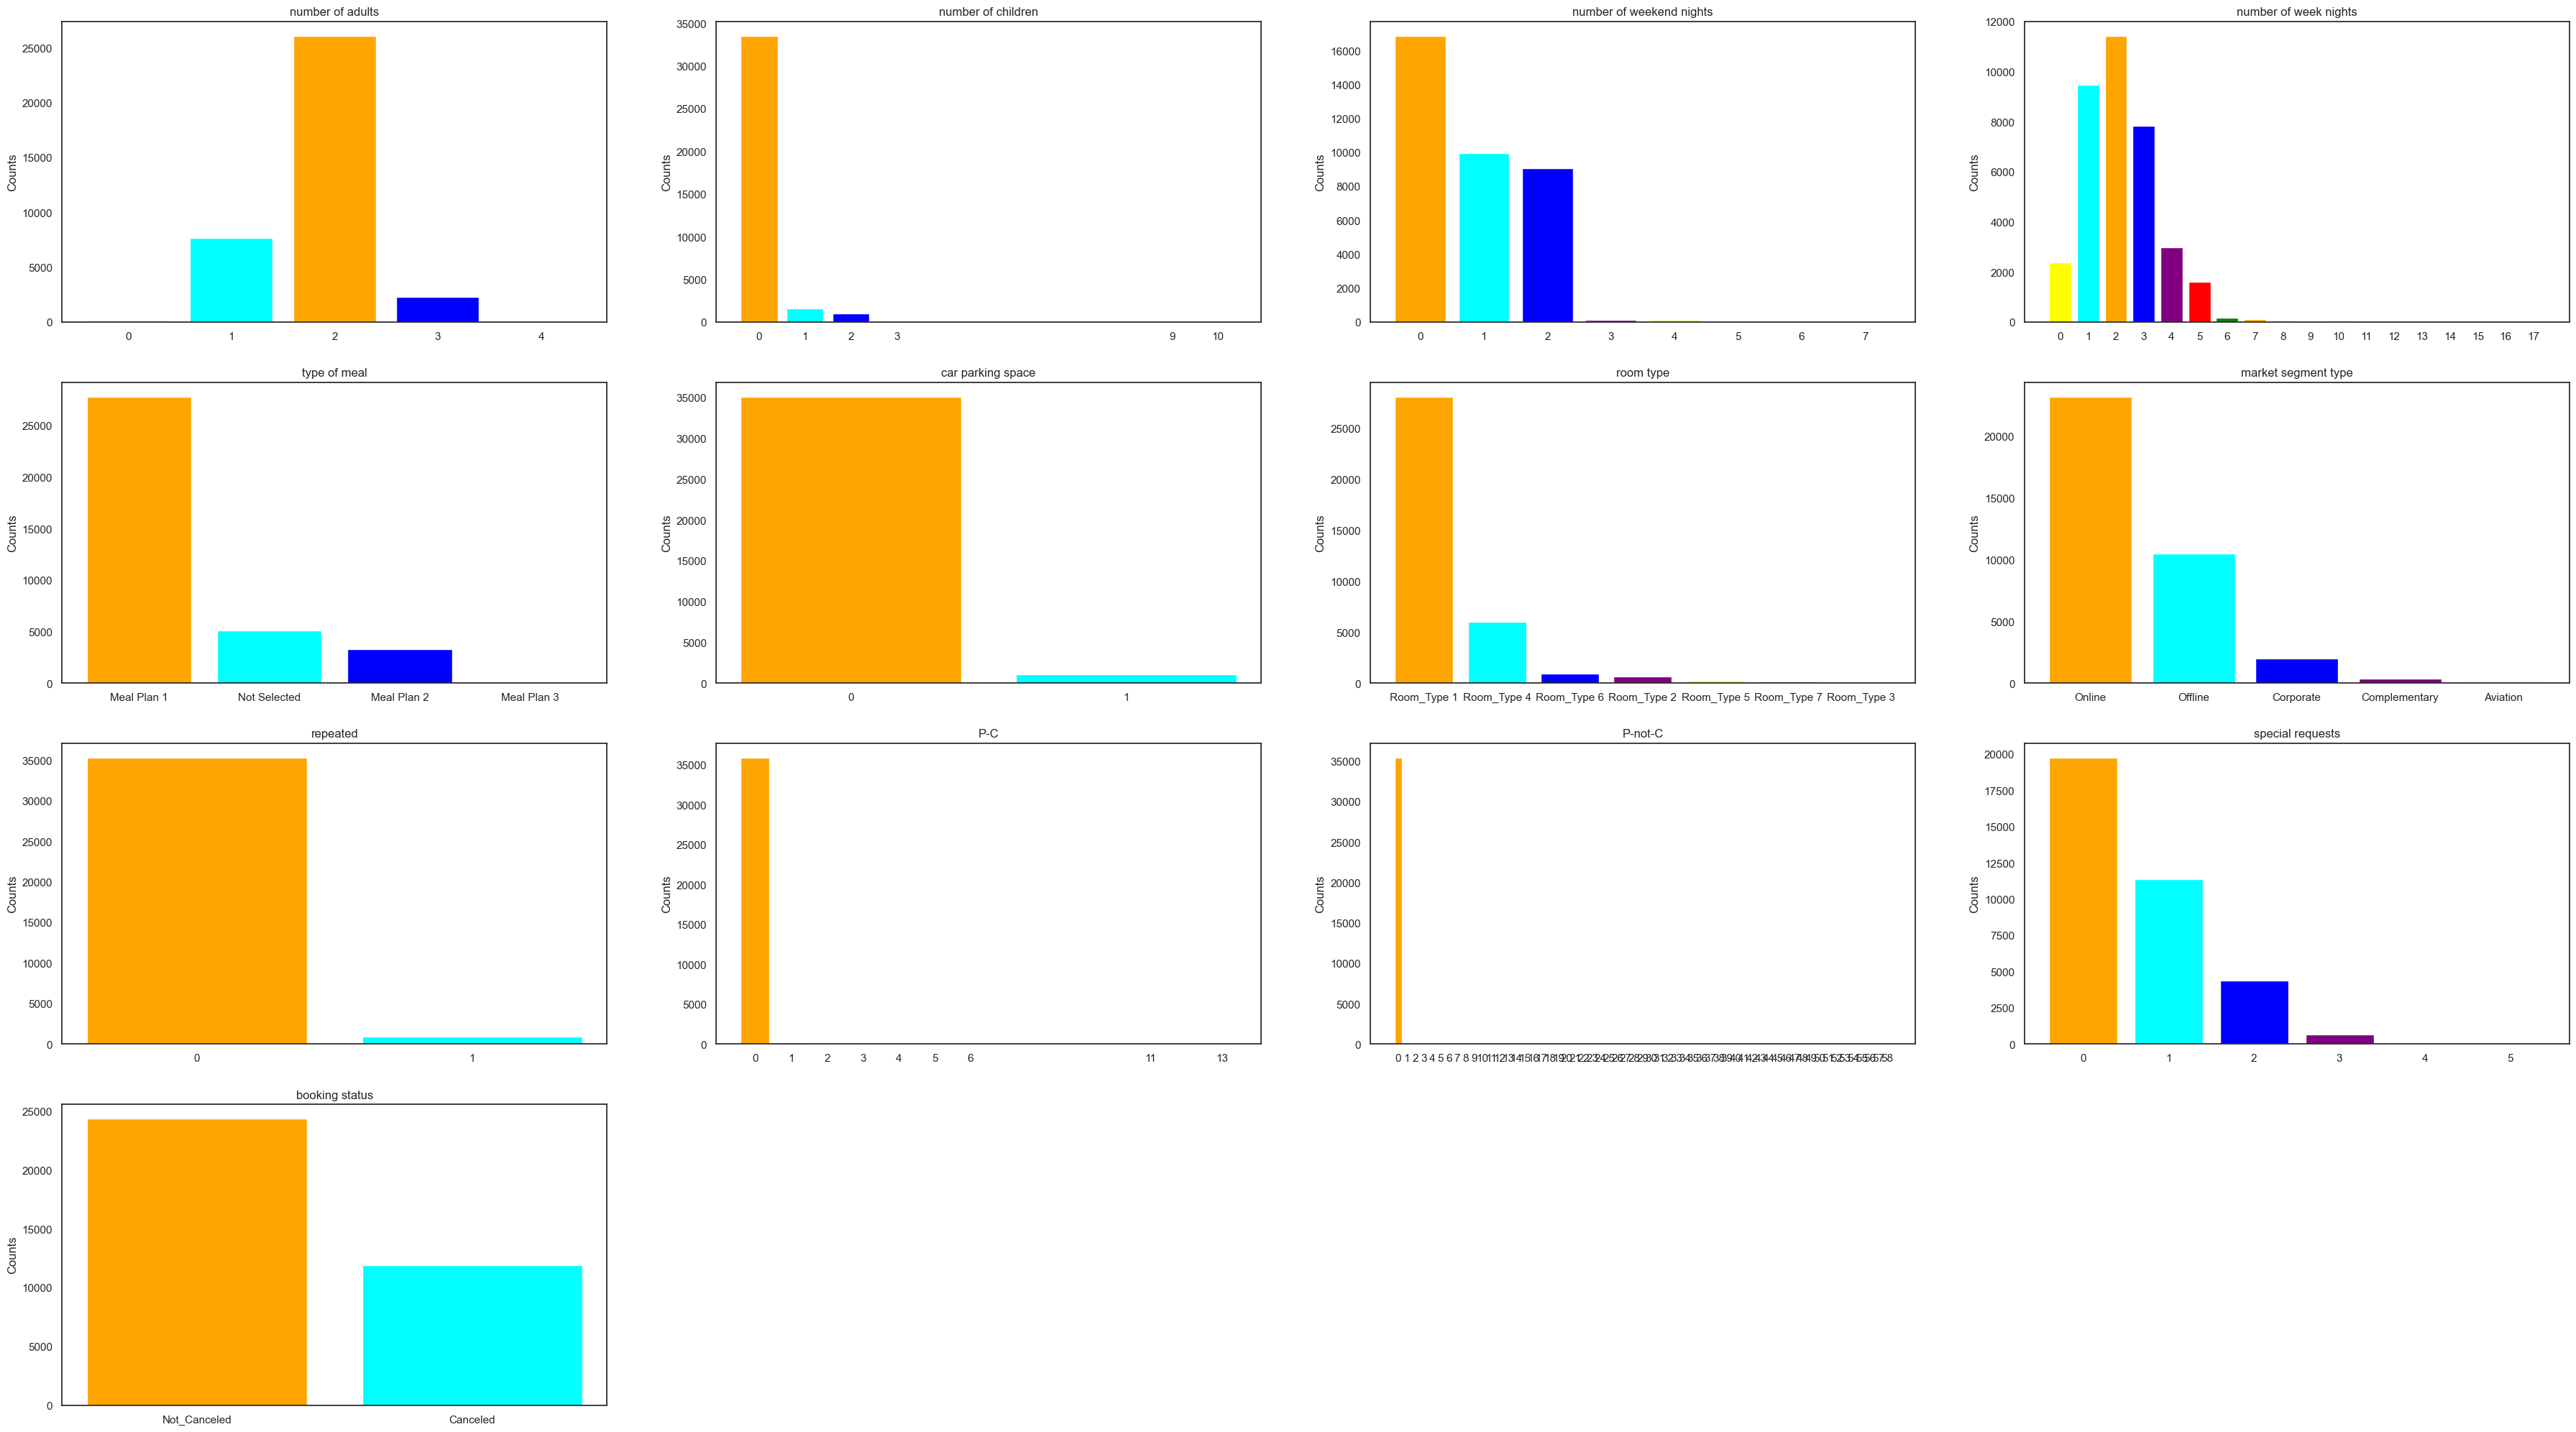

In [22]:
# Create column plots for each categorical data column as subplot
import math

fig = plt.figure(figsize=(45,25))

# Define the dimension of the subplots in the figure
nrows = int(math.sqrt(len(cat_list)))+1
ncols = int(math.sqrt(len(cat_list)))+1

# Initialize the count number, which will be used in the for loop
count = 0

for item in cat_list:
    x = []
    y = []
    
    for key, value in df[item].value_counts().items():
        x.append(key)
        y.append(value)
    ax = [None]*len(cat_list) # Initialize list of ax with None element
    color = ["orange","cyan", "blue", "purple", "yellow", "red", "green"]
    ax[count] = fig.add_subplot(nrows, ncols, count+1)
    ax[count].bar(x=x, height=y, color=color)
    ax[count].set_ylabel("Counts")
    ax[count].set_title(item)
    count += 1

    # Set xticks
    plt.xticks(x)

plt.show();

['Not_Canceled', 'Canceled']
[24366, 11882]


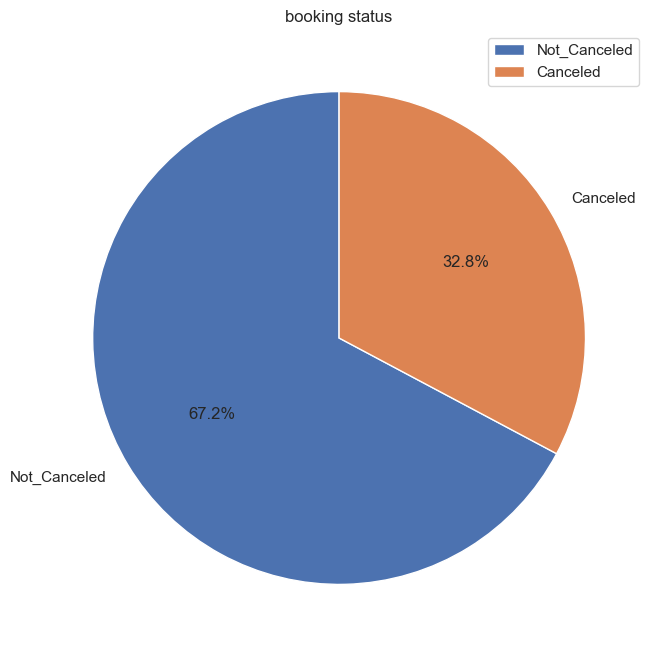

In [23]:
# Create a pie chart for target
x = []
y = []

for key, value in df["booking status"].value_counts().items():
    x.append(key)
    y.append(value)
print(x)
print(y)
color = ["orange","cyan", "blue", "purple", "yellow", "red", "green"]
plt.figure(figsize=(15,8))
plt.pie(y, labels=x, autopct='%1.1f%%', startangle=90)
plt.title("booking status")
plt.legend(loc="upper right")
plt.show();

It appears that while the classes of the target are not quite balanced, it is still not too bad.

Anyway we can still check the F1 score later in the modelling phase.

EDA: Correlation Analysis

In [24]:
# Preview the encoded DataFrame
df_dummies.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,...,room type_Room_Type 3,room type_Room_Type 4,room type_Room_Type 5,room type_Room_Type 6,room type_Room_Type 7,market segment type_Complementary,market segment type_Corporate,market segment type_Offline,market segment type_Online,booking status_Not_Canceled
0,INN00001,1,1,2,5,0,224,0,0,0,...,False,False,False,False,False,False,False,True,False,True
1,INN00002,1,0,1,3,0,5,0,0,0,...,False,False,False,False,False,False,False,False,True,True
2,INN00003,2,1,1,3,0,1,0,0,0,...,False,False,False,False,False,False,False,False,True,False
3,INN00004,1,0,0,2,0,211,0,0,0,...,False,False,False,False,False,False,False,False,True,False
4,INN00005,1,0,1,2,0,48,0,0,0,...,False,False,False,False,False,False,False,False,True,False


In [25]:
# Drop the irrelevant columns for correlation analysis
df_dummies.drop(["Booking_ID", "date of reservation"], axis=1, inplace=True)
df_dummies.head(3)

,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,...,room type_Room_Type 3,room type_Room_Type 4,room type_Room_Type 5,room type_Room_Type 6,room type_Room_Type 7,market segment type_Complementary,market segment type_Corporate,market segment type_Offline,market segment type_Online,booking status_Not_Canceled
0,1,1,2,5,0,224,0,0,0,88.00,...,False,False,False,False,False,False,False,True,False,True
1,1,0,1,3,0,5,0,0,0,106.68,...,False,False,False,False,False,False,False,False,True,True
2,2,1,1,3,0,1,0,0,0,50.00,...,False,False,False,False,False,False,False,False,True,False


In [26]:
# Check whether all the columns are encoded / already in numerical form
df_dummies.dtypes

number of adults                       int64
number of children                     int64
number of weekend nights               int64
number of week nights                  int64
car parking space                      int64
lead time                              int64
repeated                               int64
P-C                                    int64
P-not-C                                int64
average price                        float64
special requests                       int64
type of meal_Meal Plan 2                bool
type of meal_Meal Plan 3                bool
type of meal_Not Selected               bool
room type_Room_Type 2                   bool
room type_Room_Type 3                   bool
room type_Room_Type 4                   bool
room type_Room_Type 5                   bool
room type_Room_Type 6                   bool
room type_Room_Type 7                   bool
market segment type_Complementary       bool
market segment type_Corporate           bool
market seg

In [27]:
# Check the correlation of the features vs. the target by absolute values, and sort them in certain order
corr = abs(df_dummies.corr()["booking status_Not_Canceled"]).sort_values(ascending=False)[1:]
corr

lead time                            0.438583
special requests                     0.253361
average price                        0.142584
market segment type_Corporate        0.112760
repeated                             0.107479
market segment type_Online           0.106131
number of week nights                0.092732
type of meal_Meal Plan 2             0.086647
number of adults                     0.086525
car parking space                    0.086047
market segment type_Complementary    0.072827
number of weekend nights             0.061630
P-not-C                              0.060041
market segment type_Offline          0.038296
P-C                                  0.033868
number of children                   0.032962
room type_Room_Type 6                0.032876
room type_Room_Type 7                0.014088
room type_Room_Type 4                0.013317
room type_Room_Type 5                0.009841
type of meal_Meal Plan 3             0.003198
type of meal_Not Selected         

In [28]:
# Create heatmap for correlation
def correlation_heatmap(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(18, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show();

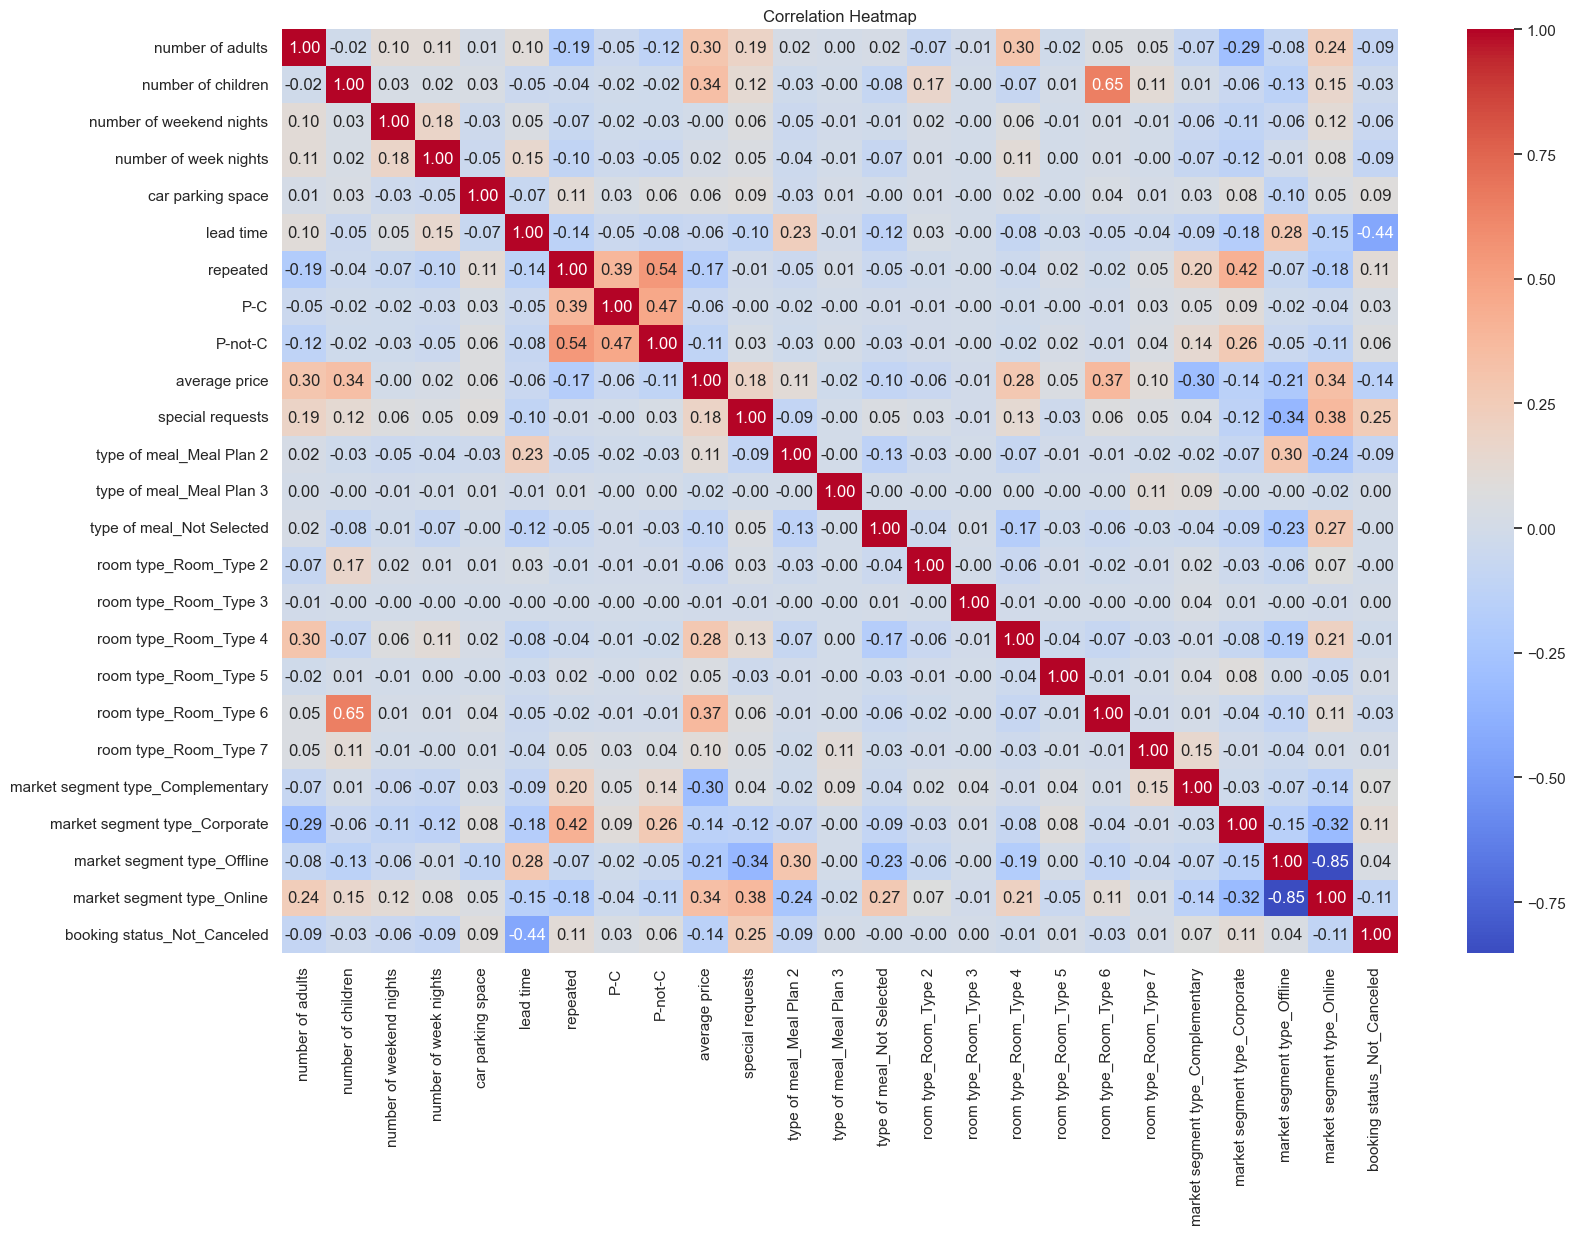

In [29]:
correlation_heatmap(df_dummies)

### 1.3 Further EDA Based on the Observations from the Heatmap

In [30]:
# Room Type 6 appears to have much higher correlation with "number of children" in relative to other room types.
# Cross-tabulate "room type" and "number of children"
contigency = pd.crosstab(df["room type"], df["number of children"])
contigency

number of children,0,1,2,3,9,10
room type,,,,,,
Room_Type 1,26765,1312,34,1,1,0
Room_Type 2,482,25,179,5,1,0
Room_Type 3,7,0,0,0,0,0
Room_Type 4,5845,190,15,0,0,1
Room_Type 5,239,13,11,0,0,0
Room_Type 6,121,64,774,5,0,0
Room_Type 7,91,16,43,8,0,0


In [31]:
# It seems that Pearson's r might have caused some issue with categorical ("room type") vs numerical data columns ("number of childrem")
# Let's try to use ANOVA instead to perform the correlation analysis between these two columns
import statsmodels.api as sm
from statsmodels.formula.api import ols

all_aov_tables = []

room_list = ['room type_Room_Type 2', 'room type_Room_Type 3', 'room type_Room_Type 4', 'room type_Room_Type 5', 'room type_Room_Type 6', 'room type_Room_Type 7']

for item in room_list:
    model = ols('Q("number of children") ~ C(Q("{}"))'.format(item), data=df_dummies).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    aov_table["room type"] = item
    all_aov_tables.append(aov_table)
    tables = pd.concat(all_aov_tables)

tables

,sum_sq,df,F,PR(>F),room type
"C(Q(""room type_Room_Type 2""))",164.474278,1.0,1043.944362,8.163373e-226,room type_Room_Type 2
Residual,5710.586608,36246.0,NaN,NaN,room type_Room_Type 2
"C(Q(""room type_Room_Type 3""))",0.077635,1.0,0.478974,4.888920e-01,room type_Room_Type 3
Residual,5874.983251,36246.0,NaN,NaN,room type_Room_Type 3
"C(Q(""room type_Room_Type 4""))",32.890900,1.0,204.061775,3.622345e-46,room type_Room_Type 4
Residual,5842.169986,36246.0,NaN,NaN,room type_Room_Type 4
"C(Q(""room type_Room_Type 5""))",0.204411,1.0,1.261151,2.614408e-01,room type_Room_Type 5
Residual,5874.856475,36246.0,NaN,NaN,room type_Room_Type 5
"C(Q(""room type_Room_Type 6""))",2479.973792,1.0,26476.236862,0.000000e+00,room type_Room_Type 6
Residual,3395.087094,36246.0,NaN,NaN,room type_Room_Type 6


In [32]:
# Cross-tabulate "market segment type" and "repeated"
contigency_2 = pd.crosstab(df["market segment type"], df["repeated"])
contigency_2

repeated,0,1
market segment type,,
Aviation,109,16
Complementary,264,126
Corporate,1412,599
Offline,10431,90
Online,23106,95


In [33]:
# Split the data columns into continuous and categorical variables
# We only want to use continuous data to create boxplot

for item in df_dummies.columns:
    print(f"{item}: {df_dummies[item].nunique()}")


number of adults: 5
number of children: 6
number of weekend nights: 8
number of week nights: 18
car parking space: 2
lead time: 352
repeated: 2
P-C: 9
P-not-C: 59
average price: 3919
special requests: 6
type of meal_Meal Plan 2: 2
type of meal_Meal Plan 3: 2
type of meal_Not Selected: 2
room type_Room_Type 2: 2
room type_Room_Type 3: 2
room type_Room_Type 4: 2
room type_Room_Type 5: 2
room type_Room_Type 6: 2
room type_Room_Type 7: 2
market segment type_Complementary: 2
market segment type_Corporate: 2
market segment type_Offline: 2
market segment type_Online: 2
booking status_Not_Canceled: 2


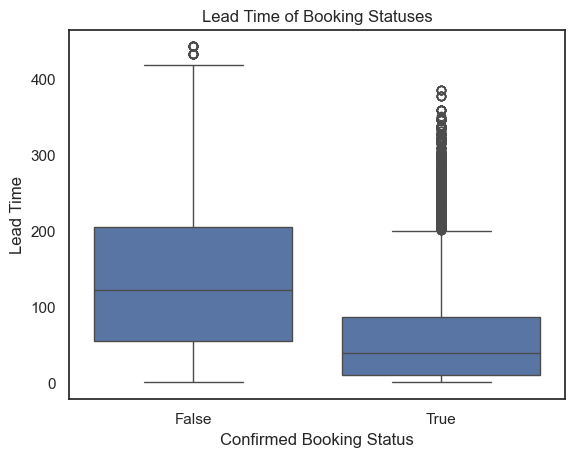

In [34]:
# Plot lead time vs booking status
sns.boxplot(x=df_dummies["booking status_Not_Canceled"], y=df_dummies["lead time"])
plt.xlabel("Confirmed Booking Status")
plt.ylabel("Lead Time")
plt.title("Lead Time of Booking Statuses")
plt.show();

In [35]:
# Define a function to create boxplots
def boxplot_subplots(df, list_of_headers):
    """
    Input a DataFrame and the list of its column headers of continuous variables, and it will generate all the boxplots
    """
    import math

    nrows = int(math.sqrt(len(list_of_headers))) + 1
    ncols = int(math.sqrt(len(list_of_headers))) + 1

    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10))

    for ax, column in zip(axs.flatten(), list_of_headers):
        sns.boxplot(x=df[column], ax=ax, color='skyblue')
        ax.set_title(f"Boxplot of {column}", fontsize=10)
        ax.set_xlabel('')

    # Remove empty subplots
    for ax in axs.flatten()[len(list_of_headers):]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

In [36]:
# Only include continuous data in the boxplots, namely "lead time" and "average price"
list_of_headers = ["lead time", "average price"]

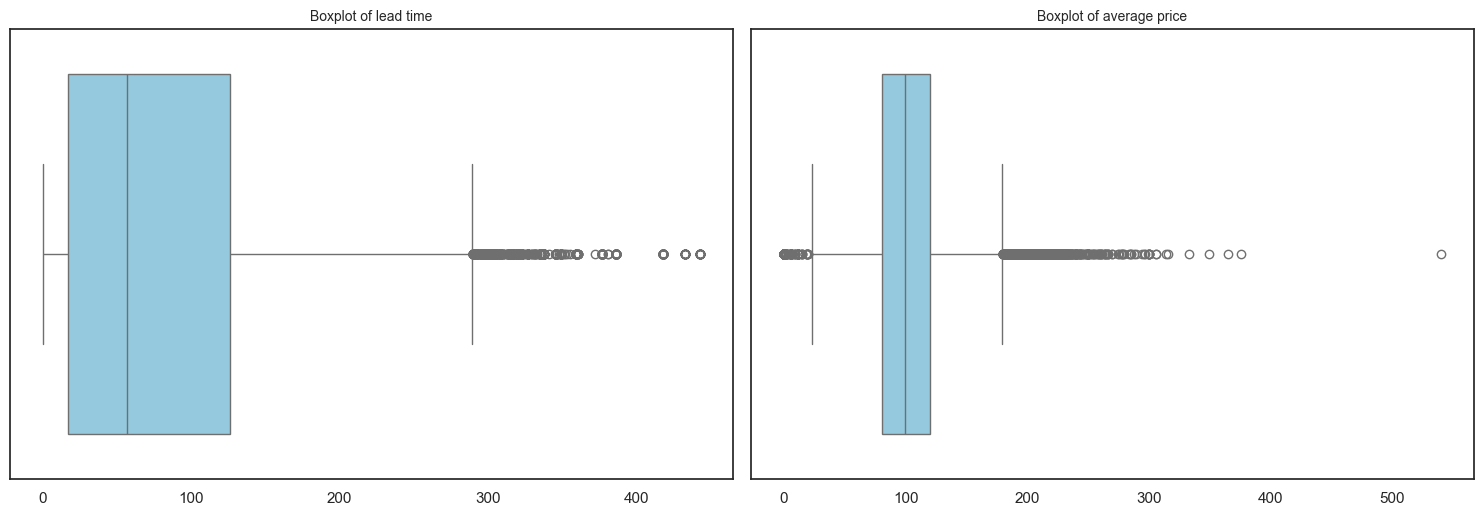

In [37]:
boxplot_subplots(df_dummies, list_of_headers)

In [38]:
# Define a function to remove the extreme outliers
def remove_outliers(df, column_list, excluded_outliers = 2):
    """ 
    1. Pass a Pandas DataFrame.
    2. Pass a list of columns that we want this function to exclude the respective outliers from.
    3. For "excluded_outliers", set the amount of IQR as exclusion threshold. The SMALLER number it gets the MORE outliers will be excluded.
    """
    for item in column_list:
        Q1 = df[item].quantile(0.25)
        Q3 = df[item].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[item] < (Q1 - excluded_outliers * IQR)) | (df[item] > (Q3 + excluded_outliers * IQR))].index
        df.drop(outliers, axis=0, inplace=True)
        # df_out = df[~((df[item] < (Q1 - excluded_outliers * IQR)) | (df[item] > (Q3 + excluded_outliers * IQR)))]
    return df

In [39]:
df = remove_outliers(df_dummies, list_of_headers, excluded_outliers=1.5)

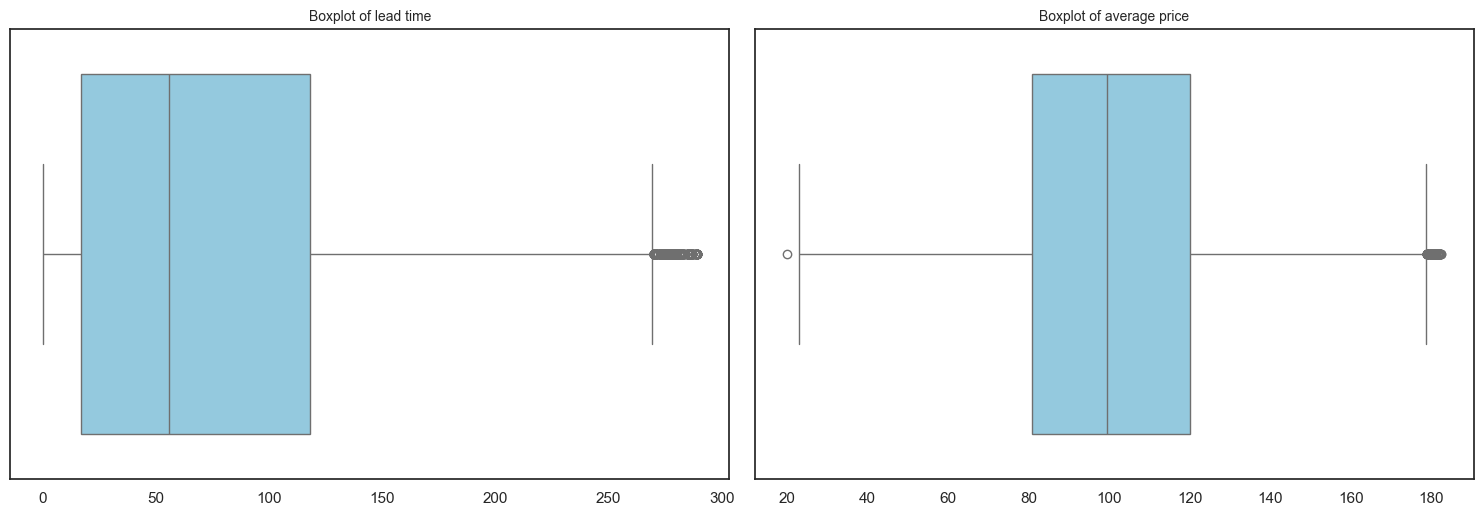

In [40]:
# Check the boxplots again
boxplot_subplots(df_dummies, list_of_headers)

In [41]:
# Check the shape of the DataFrame after removing the extreme outliers of "lead time" and "average price"
df.shape

(33312, 25)

## 2. Machine Learning Model Building

### Split the dataset into training, validation and testing sets

In [42]:
# Preview the one-hot encoded DataFrame
df_dummies.head(3)

,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,...,room type_Room_Type 3,room type_Room_Type 4,room type_Room_Type 5,room type_Room_Type 6,room type_Room_Type 7,market segment type_Complementary,market segment type_Corporate,market segment type_Offline,market segment type_Online,booking status_Not_Canceled
0,1,1,2,5,0,224,0,0,0,88.00,...,False,False,False,False,False,False,False,True,False,True
1,1,0,1,3,0,5,0,0,0,106.68,...,False,False,False,False,False,False,False,False,True,True
2,2,1,1,3,0,1,0,0,0,50.00,...,False,False,False,False,False,False,False,False,True,False


In [43]:
# Check which columns are of continous (numerical) data
df_dummies.nunique()

number of adults                        5
number of children                      6
number of weekend nights                8
number of week nights                  18
car parking space                       2
lead time                             290
repeated                                2
P-C                                     9
P-not-C                                59
average price                        3513
special requests                        6
type of meal_Meal Plan 2                2
type of meal_Meal Plan 3                1
type of meal_Not Selected               2
room type_Room_Type 2                   2
room type_Room_Type 3                   2
room type_Room_Type 4                   2
room type_Room_Type 5                   2
room type_Room_Type 6                   2
room type_Room_Type 7                   2
market segment type_Complementary       2
market segment type_Corporate           2
market segment type_Offline             2
market segment type_Online        

In [44]:
# Scale all the numerical columns with StandardScaler
scaler = StandardScaler()
df_dummies[["lead time", "average price"]] = scaler.fit_transform(df_dummies[["lead time", "average price"]])
df_dummies.head(3)


,number of adults,number of children,number of weekend nights,number of week nights,car parking space,lead time,repeated,P-C,P-not-C,average price,...,room type_Room_Type 3,room type_Room_Type 4,room type_Room_Type 5,room type_Room_Type 6,room type_Room_Type 7,market segment type_Complementary,market segment type_Corporate,market segment type_Offline,market segment type_Online,booking status_Not_Canceled
0,1,1,2,5,0,2.007316,0,0,0,-0.525717,...,False,False,False,False,False,False,False,True,False,True
1,1,0,1,3,0,-0.999661,0,0,0,0.148100,...,False,False,False,False,False,False,False,False,True,True
2,2,1,1,3,0,-1.054582,0,0,0,-1.896437,...,False,False,False,False,False,False,False,False,True,False


In [45]:
# Define the features (X) and target (y)
X = df_dummies.drop("booking status_Not_Canceled", axis=1)
y = df_dummies["booking status_Not_Canceled"].to_frame()
X.shape, y.shape, type(X), type(y)

((33312, 24),
 (33312, 1),
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [46]:
# Split out the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_test.shape, y_test.shape

((6663, 24), (6663, 1))

In [47]:
# And then split the remaining data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((21319, 24), (5330, 24), (21319, 1), (5330, 1))

At this point we have training, validation and test data sets.
1. Training set: For ML model training, selection and cross validation purposes
2. Validation set: Used for ML model hyperparameters tuning (RandomizedSearchCV) and evaluation
3. Test set: Used for final evaluation of the optmimized ML model

In [48]:
# Define a function to perform model fitting and output Accuracy, Precision, Recall and F1 scores with cross_val_score

def model_fit_score(X, y, model, random_state=1, n_splits=5):
    """ 
    1. Pass X and y (train and test) data
    2. Pass a model to be fitted with
    3. Optional: Set the random_state, random_state=
    4. Optional: Set how many splits (a.k.a. cv), n_splits=
    """
    
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    start_time = time.time()

    accuracy = round(np.array(cross_val_score(model, X, y, cv=cv, scoring="accuracy")).mean(), 4)
    precision = round(np.array(cross_val_score(model, X, y, cv=cv, scoring="precision")).mean(), 4)
    recall = round(np.array(cross_val_score(model, X, y, cv=cv, scoring="recall")).mean(), 4)
    f1 = round(np.array(cross_val_score(model, X, y, cv=cv, scoring="f1")).mean(), 4)

    end_time = time.time()

    elapsed_time = end_time - start_time

    df = pd.DataFrame({
        "Accuracy": [accuracy],
        "Precision": [precision],
        "Recall": [recall],
        "F1": [f1],
        "Elapsed Time": [elapsed_time]
    }, index=[model])

    return df


In [49]:
# Create a list of models to be evaluated
model_list = [LogisticRegression(max_iter=1000), RandomForestClassifier() ,GaussianNB(), SVC(), NuSVC(), LinearSVC(), HistGradientBoostingClassifier(), XGBClassifier() , SGDClassifier()]

In [50]:
# Instantiate an empty list to collect the evaluation results of each model
df_list = []

# Loop through the list of models and fit, evaluate the performance of each model.
for item in model_list:
    df = model_fit_score(X_train, y_train, item, random_state=42, n_splits=5)
    df_list.append(df)

results = pd.concat(df_list)
results

,Accuracy,Precision,Recall,F1,Elapsed Time
LogisticRegression(max_iter=1000),0.7998,0.8264,0.8965,0.8599,3.976320
RandomForestClassifier(),0.8746,0.8931,0.9266,0.9099,59.129944
GaussianNB(),0.3875,0.8866,0.1229,0.2158,0.677397
SVC(),0.8235,0.8306,0.9330,0.8788,302.500470
NuSVC(),0.8004,0.8068,0.9324,0.8650,284.273314
LinearSVC(),0.7987,0.8240,0.8985,0.8596,12.987852
HistGradientBoostingClassifier(),0.8686,0.8834,0.9320,0.9075,19.210456
"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)",0.8710,0.8869,0.9305,0.9082,2.786862
SGDClassifier(),0.7820,0.8175,0.9274,0.8575,1.384755


Discussions:
1. From the models fitting and evualuation, it seems that `RandomForestClassifier` scores fairly high in general, especially in `Accuracy` and `Recall`.
2. On top of that, the training time needed for `RandomForestClassifier` is also acceptable.
3. Gradient Boosting models such as HistGradientBoostingClassifier and XGBoostClassifier have higher risk of overfitting due to their tendency of picking up noise and outliers in the training data (learning too well on the training data, and resulting in poorer generalization). So unless gradient boosting algorithms yield significantly better performance than the conventional ML models, we prefer not to go with these gradient boosting models.
3. `F1` score can also be taken as reference since the two classes are slightly imbalanced.

Now that we've chosen our ML model, let's optimize the model by filtering the features included.

In [51]:
# Check the scoring with RandomForestClassifier again
model_fit_score(X_train, y_train, RandomForestClassifier(), random_state=42, n_splits=5)

,Accuracy,Precision,Recall,F1,Elapsed Time
RandomForestClassifier(),0.8744,0.8936,0.9269,0.9107,42.487802


In [52]:
# Check the important features
model = RandomForestClassifier()
model.fit(X_train, y_train)
model.feature_importances_
X_train.columns

importance = pd.DataFrame(zip(X_train.columns, model.feature_importances_), columns=["Feature", "Importance"])
importance.sort_values("Importance", ascending=False)

,Feature,Importance
5,lead time,0.409929
9,average price,0.238665
10,special requests,0.112947
3,number of week nights,0.067112
2,number of weekend nights,0.041569
23,market segment type_Online,0.026935
0,number of adults,0.024115
22,market segment type_Offline,0.016094
16,room type_Room_Type 4,0.010416
13,type of meal_Not Selected,0.010310


In [53]:
# Check on the correlation again with the target "booking status"
corr

lead time                            0.438583
special requests                     0.253361
average price                        0.142584
market segment type_Corporate        0.112760
repeated                             0.107479
market segment type_Online           0.106131
number of week nights                0.092732
type of meal_Meal Plan 2             0.086647
number of adults                     0.086525
car parking space                    0.086047
market segment type_Complementary    0.072827
number of weekend nights             0.061630
P-not-C                              0.060041
market segment type_Offline          0.038296
P-C                                  0.033868
number of children                   0.032962
room type_Room_Type 6                0.032876
room type_Room_Type 7                0.014088
room type_Room_Type 4                0.013317
room type_Room_Type 5                0.009841
type of meal_Meal Plan 3             0.003198
type of meal_Not Selected         

Discussions:
1. By comparing the `feature_importance_` and the `Pearson's Correlation` that we computed earlier in this project, we notice that the importance of the features are not exactly the same. Hence it's important to note that while Pearson's correlation analysis is important for our features selection early on, it's important to check and optimize the model based on the feature_importance_ once we have identified the ML model that we are going to use.
2. This is simply because `feature_importance_` is very specific to the particular ML model that we choose.

1st features selection attempt: Remove all the features as a whole with importance < 0.08

In [54]:
# Drop "room type", "type of meal", "P-not-C", "P-C", "number of children", "car parking space", "repeated", "market segment type"
# Note: For one-hot encoded features, if at least one of the individual one-hot encoded columns is insignificant, the entire feature will be excluded as a whole
X_train_2 = X_train[["lead time", "average price", "special requests", "number of week nights", "number of weekend nights", "number of adults"]]

In [55]:
X_train_2.head()

,lead time,average price,special requests,number of week nights,number of weekend nights,number of adults
6374,-1.054582,2.792869,1,4,0,2
14608,-0.120909,-0.742146,0,2,1,2
24746,1.801359,-0.226323,1,3,2,2
9465,0.551885,0.065857,1,1,2,2
8663,1.114835,-1.175005,1,1,1,2


In [56]:
# Fit the model RandomForestClassifier with the new X_train
model_fit_score(X_train_2, y_train, RandomForestClassifier(), random_state=42, n_splits=5)

,Accuracy,Precision,Recall,F1,Elapsed Time
RandomForestClassifier(),0.8593,0.8747,0.9239,0.8998,46.904539


The performance seems to be worse than the original X_train, perhaps in the first features selection attempy there were too many features have been removed.

Try not to remove the entire feature as a whole, but just the individual one-hot encoded columns

2nd features selection trial attempt: Remove the individual one-hot encoded column (NOT the whole feature) step-by-step in backward until the model doesn't improve any further.

In [57]:
# Check the feature_importances_ and sort it in ascending order
importance_ascending = importance.sort_values("Importance", ascending=True)
importance_ascending

,Feature,Importance
12,type of meal_Meal Plan 3,0.000000
15,room type_Room_Type 3,0.000014
20,market segment type_Complementary,0.000046
19,room type_Room_Type 7,0.000258
7,P-C,0.000553
18,room type_Room_Type 6,0.001437
8,P-not-C,0.001594
17,room type_Room_Type 5,0.002287
6,repeated,0.002486
14,room type_Room_Type 2,0.003286


In [58]:
# Define a function to perform features backward selection
def backward_selection_classifier(X, y, model, metric, sorted_feature_importances, random_state=42, n_splits=5):
    """ 
    1. Pass predictors X in DataFrame
    2. Pass the response y in DataFrame
    3. Pass the model to be fitted and evaluated
    4. Pass the metric of evaluation. E.g. "accuracy", "precision", "recall", "f1" and etc.
    5. Pass the SORTED feature_importances_ in DataFrame in ASCENDING. The first column has to be feature names, whereas the second column has to be their respective importance score.
    6. Optional: Set the random_state. Default value is 42
    7. Optional: Set the n_splits. Default value is 5
    """
    
    # Instantiate the list of features and the metric_list
    features = sorted_feature_importances.iloc[:,0].to_list()
    metric_list = []

    # Loop through the features and evaluate
    for item in features:
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        metric_score = round(np.array(cross_val_score(model, X[features], y, cv=cv, scoring=metric)).mean(), 4)
        print(f"With features {features}, the metric score is: {metric_score}")

        if len(metric_list) > 0 and metric_score < metric_list[-1]:
            metric_list.append(metric_score)
            print(f"The best score is {metric_list[-2]} with features {features}")
            break
        
        else:
            metric_list.append(metric_score)
            features.pop(0)

In [59]:
# Perform backward elimination
backward_selection_classifier(X_train, y_train, RandomForestClassifier(), "accuracy", importance_ascending, random_state=42, n_splits=5)

With features ['type of meal_Meal Plan 3', 'room type_Room_Type 3', 'market segment type_Complementary', 'room type_Room_Type 7', 'P-C', 'room type_Room_Type 6', 'P-not-C', 'room type_Room_Type 5', 'repeated', 'room type_Room_Type 2', 'market segment type_Corporate', 'number of children', 'car parking space', 'type of meal_Meal Plan 2', 'type of meal_Not Selected', 'room type_Room_Type 4', 'market segment type_Offline', 'number of adults', 'market segment type_Online', 'number of weekend nights', 'number of week nights', 'special requests', 'average price', 'lead time'], the metric score is: 0.8741
With features ['room type_Room_Type 3', 'market segment type_Complementary', 'room type_Room_Type 7', 'P-C', 'room type_Room_Type 6', 'P-not-C', 'room type_Room_Type 5', 'repeated', 'room type_Room_Type 2', 'market segment type_Corporate', 'number of children', 'car parking space', 'type of meal_Meal Plan 2', 'type of meal_Not Selected', 'room type_Room_Type 4', 'market segment type_Offline'

It still seems that not removing any feature at all is the best thing to do.

Let's try backward elimination again but this time around we will NOT stop running even if the `Accuracy` score doesn't improve or even decrease.

This is because we want to see if we used to stop too early and missed out any chance of getting better filtered features.

3rd features selection attempt:
1. Remove the individual one-hot encoded column (NOT the whole feature) step-by-step in backward but never stop at all until there is no more feature left.
2. Plot and evaluate the changes of the `accuracy` score, and identify the best combination of features manually.

In [60]:
# Re-define backward selection function without stopping at all
def new_backward_selection_classifier(X, y, model, metric, sorted_feature_importances, random_state=42, n_splits=5):
    """ 
    1. Pass predictors X in DataFrame
    2. Pass the response y in DataFrame
    3. Pass the model to be fitted and evaluated
    4. Pass the metric of evaluation. E.g. "accuracy", "precision", "recall", "f1" and etc.
    5. Pass the SORTED feature_importances_ in DataFrame in ASCENDING. The first column has to be feature names, whereas the second column has to be their respective importance score.
    6. Optional: Set the random_state. Default value is 42
    7. Optional: Set the n_splits. Default value is 5
    """
    
    # Instantiate the list of features and the metric_list
    features = sorted_feature_importances.iloc[:,0].to_list()
    metric_list = []

    # Loop through the features and evaluate
    for item in features.copy():
        cv = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        metric_score = round(np.array(cross_val_score(model, X[features], y, cv=cv, scoring=metric)).mean(), 4)
        print(f"With features {features}, the metric score is: {metric_score}")

        metric_list.append(metric_score)
        features.pop(0)
        
    return metric_list

In [61]:
metric_list = new_backward_selection_classifier(X_train, y_train, RandomForestClassifier() ,"accuracy", importance_ascending, random_state=42, n_splits=5)

With features ['type of meal_Meal Plan 3', 'room type_Room_Type 3', 'market segment type_Complementary', 'room type_Room_Type 7', 'P-C', 'room type_Room_Type 6', 'P-not-C', 'room type_Room_Type 5', 'repeated', 'room type_Room_Type 2', 'market segment type_Corporate', 'number of children', 'car parking space', 'type of meal_Meal Plan 2', 'type of meal_Not Selected', 'room type_Room_Type 4', 'market segment type_Offline', 'number of adults', 'market segment type_Online', 'number of weekend nights', 'number of week nights', 'special requests', 'average price', 'lead time'], the metric score is: 0.8751
With features ['room type_Room_Type 3', 'market segment type_Complementary', 'room type_Room_Type 7', 'P-C', 'room type_Room_Type 6', 'P-not-C', 'room type_Room_Type 5', 'repeated', 'room type_Room_Type 2', 'market segment type_Corporate', 'number of children', 'car parking space', 'type of meal_Meal Plan 2', 'type of meal_Not Selected', 'room type_Room_Type 4', 'market segment type_Offline'

In [62]:
max(metric_list)

## With features ['P-not-C', 'room type_Room_Type 5', 'room type_Room_Type 2', 'repeated', 'market segment type_Corporate', 'car parking space', 'number of children', 'type of meal_Meal Plan 2', 'type of meal_Not Selected', 'room type_Room_Type 4', 'market segment type_Offline', 'market segment type_Online', 'number of adults', 'number of weekend nights', 'number of week nights', 'special requests', 'average price', 'lead time'], the metric score is: 0.8751

0.8755

It appears that with the 2nd attempt of backward elimination, we've indeed stopped too early because as we dropped a few more features further in our 3rd attempt, the model actually got a little better!

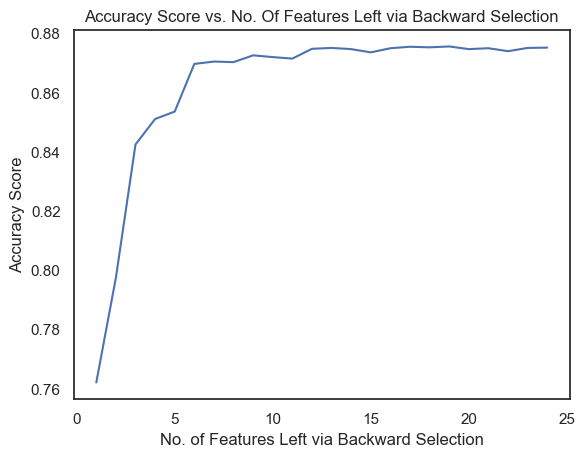

In [63]:
# Plot the `Accuracy` score versus the number of features left
plt.plot(range(len(metric_list), 0, -1), metric_list)
plt.xlabel("No. of Features Left via Backward Selection")
plt.ylabel("Accuracy Score")
plt.title("Accuracy Score vs. No. Of Features Left via Backward Selection")
plt.show();

### Optimize the model with hyperparameter tuning

In [64]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
params = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
    }

In [65]:
# Perform hyperparameters tuning with X_train and y_train, to see if there is any improvement over the baseline of `accuracy` = 0.8762
# Will use X_val and y_val after this if we see any improvement with hyperparameter tuning
# Try with RandomizedSearchCV()

random_search = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=params, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1, scoring="accuracy")

random_search.fit(X_val, y_val)

random_best_params = random_search.best_params_
random_best_model = random_search.best_estimator_
random_best_score = random_search.best_score_
random_best_scorer = random_search.scorer_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [66]:
random_best_params

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

In [67]:
random_best_model

RandomForestClassifier(max_depth=100, min_samples_split=5, n_estimators=2000)

In [68]:
random_best_score

0.8545969647193621

In [69]:
random_best_scorer

make_scorer(accuracy_score)

In [70]:
# Check the performance with the validation data
# model_fit_score(X_val, y_val, random_best_model, random_state=42, n_splits=5)

In [71]:
# Perform final evaluation of model performance with test dataset
model_fit_score(X_test, y_test, random_best_model, random_state=42, n_splits=5)

Accuracy  Precision  \
(DecisionTreeClassifier(max_depth=100, max_feat...    0.8589      0.878   

                                                    Recall      F1  \
(DecisionTreeClassifier(max_depth=100, max_feat...  0.9246  0.9004   

                                                    Elapsed Time  
(DecisionTreeClassifier(max_depth=100, max_feat...    302.825508

Discussions:
1. With the optimized model, I manage to get about 87.55% of `accuracy` score with training data, 85.46% with validation data, and 85.89% with test data.
2. It proves that the optimized model above is quite stable in performance even with various data sets that the model has not "seen" before, hence there doesn't seem to be any overfitting issue.
3. On Kaggle, while there are other contributors who managed to get better `accuracy` scores than what this project does (90% or even 95%), it's worth noticing that:
    1. Some of them don't use cross validation with several K-Fold to evaluate their model with data of different splits, hence there could be variations in their model performance.
    2. Some of them also didn't set random_state when they fitted their model. As a result the seemingly high `accuracy` score could possibly be due to variations.
    3. Some of them oversampled their dataset. While it makes sense in a way since the classes are kind of imbalanced, oversampling is an assumption itself. Whether or not oversampling can still allow the model to perform reliably with the data that the model has not "seen" before, further testing and exploration is needed.
4. The ML part can probably be further studied and optimized but this will be it for mini project 1.

#### That's the end of this Mini Project 1, and I would like to hear your opinions and comments on my works, thank you!
#### Email: yuehangdata@outlook.com
#### Let's connect on LinkedIn: [Yue Hang Tan](https://www.linkedin.com/in/yuehangtan/)